In [65]:
using BenchmarkTools
using Plots

N = 1000
L = 2*π
dx = L / N

# Finite difference coeficcients, https://en.wikipedia.org/wiki/Finite_difference_coefficient
# co = [1/2] / dx
co = [2/3, -1/12] / dx
# co = [3/4, -3/20, 1/60]  / dx
# co = [4/5, -1/5, 4/105, -1/280] / dx

order = length(co)

@inline ind(i) = mod(i-1, N)+1

@inline function ∇(A, i)
	d = 0.
	@inbounds for j in 1:order
		d += co[j]*( A[ind(i+j)] - A[ind(i-j)] ) 
	end
	return d
end

@inline function ∇T(A::Array{Float64}, i::Int)
	d = 0.
	@inbounds for j in 1:order
		d += co[j]*( A[ind(i+j)] - A[ind(i-j)] ) 
	end
	return d
end

∇T (generic function with 1 method)

In [ ]:
x = collect(LinRange(0, L-dx, N))
y = sin.(2*π*x/L)
@btime ∇T(y, 1)
@btime ∇T($y, 1)
@btime ∇(y, 1)
@btime ∇($y, 1)

In [ ]:
dy = zeros(N)

function fT!(dy, y)
    for i in axes(y,1)
        dy[i] = ∇T(y, i)
    end
end

function f!(dy, y)
    for i in axes(y,1)
        dy[i] = ∇(y, i)
    end
end

fT!(dy, y)
plot(x, y)
plot!(x, dy)

In [ ]:
@btime fT!($dy, $y)
@btime f!(dy, y)
@btime f!($dy, $y)

In [ ]:
x  = zeros(N)
x .= collect(LinRange(0, L-dx, N))

z1 = zeros(N, 2)
z1[:, 1] = sin.(2*π*x/L)
z1[:, 2] = cos.(2*π*x/L)

plot(x, z1[:, 1]) 
plot!(x, z1[:, 2])

In [ ]:
@btime ∇T(y[:, 1], 1)
@btime ∇T($y[:, 1], 1)
@btime @views ∇(y[:, 1], 1)
@btime @views ∇($y[:, 1], 1)

In [ ]:
z1 = zeros(N, 2)
@. @views z1[:, 1] = sin(x)
@. @views z1[:, 2] = cos(x)

dz1 = zeros(N, 2)

function g1!(z1, dz1)
    @inbounds for i in 1:N 
        @views dz1[i, 1] = ∇(z1[:, 1], i)
        @views dz1[i, 2] = ∇(z1[:, 2], i)
    end
end

g1!(z1, dz1)
@btime g1!($z1, $dz1)

In [ ]:
plot(x[:, 1], z1[:, 1])
plot!(x[:, 1], dz1[:, 1])

In [ ]:
z2 = zeros(2, N)
z2[1, :] .= sin.(x)
z2[2, :] .= cos.(x)

dz2 = zeros(2, N)

function g2!(z2, dz2)
    @inbounds for i in 1:N
        @views dz2[1, i] = ∇(z2[1, :], i)
        @views dz2[2, i] = ∇(z2[2, :], i)
    end
end

@btime g2!(z2, dz2)

In [ ]:
@inline function ∇²(A, i)
	d = 0.
	@inbounds for j in 1:order
		d += co[j]*( ∇(A, ind(i+j)) - ∇(A, ind(i-j))  ) 
	end
	return d
end

In [ ]:
@btime ∇²(y, 1)
@btime ∇²($y, 1)

In [ ]:
dy = zeros(N)

function f2!(dy, y)
    @inbounds for i in 1:N
        dy[i] = ∇²(y, i)
    end
end

f!(dy, y)
plot(x, y)
plot!(x, dy)

In [ ]:
@btime f!(dy, y)
@btime f!($dy, $y)

In [ ]:
@btime f2!(dy, y)
@btime f2!($dy, $y)

In [ ]:
z1 = zeros(N, 2)
@. @views z1[:, 1] = sin(x)
@. @views z1[:, 2] = cos(x)

dz1 = zeros(N, 2)

function h1!(z1, dz1)
    @inbounds for i in 1:N 
        @views dz1[i, 1] = ∇²(z1[:, 1], i)
        @views dz1[i, 2] = ∇²(z1[:, 2], i)
    end
end

g1!(z1, dz1)
@btime h1!($z1, $dz1)

In [ ]:
plot(x, y)
plot!(x, dy)

In [ ]:
@inline ∇(A, i)  = co[1]  * (A[ind(i+1)] - A[ind(i-1)]) + co[2] * (A[ind(i+2)] - A[ind(i-2)])
@inline ∇²(A, i) = co[1]  * (∇(A, i + 1) - ∇(A, i - 1)) + co[2] * (∇(A, i + 2) - ∇(A, i - 2))

In [ ]:
z1 = zeros(N, 2)
@. @views z1[:, 1] = sin(x)
@. @views z1[:, 2] = cos(x)

dz1 = zeros(N, 2)

function F!(z1, dz1)
    @inbounds for i in 1:N 
        @views dz1[i, 1] = ∇ol²(z1[:, 1], dx, i)
        @views dz1[i, 2] = ∇ol²(z1[:, 2], dx,  i)
    end
end

@btime F!($z1, $dz1)

In [ ]:
@btime ∇ol²($y, dx, 1)

In [ ]:
@btime ∇²($y, 1)

In [119]:
pp(x) = show(IOContext(stdout, :limit => false), "text/plain", x)
A = [
    0 2/3 -1/12 0 0 0 0 0 0 -1/12 2/3;
    2/3 0 2/3 -1/12 0 0 0 0 0 0 -1/12;
    -1/12 2/3 0 2/3 -1/12 0 0 0 0 0 0;
    0 -1/12 2/3 0 2/3 -1/12 0 0 0 0 0;
    0 0 -1/12 2/3 0 2/3 -1/12 0 0 0 0;
    0 0 0 -1/12 2/3 0 2/3 -1/12 0 0 0;
    0 0 0 0 -1/12 2/3 0 2/3 -1/12 0 0;
    0 0 0 0 0 -1/12 2/3 0 2/3 -1/12 0;
    0 0 0 0 0 0 -1/12 2/3 0 2/3 -1/12;
    -1/12 0 0 0 0 0 0 -1/12 2/3 0 2/3;
    2/3 -1/12 0 0 0 0 0 0 -1/12 2/3 0;
]
pp(A)

11×11 Matrix{Float64}:
  0.0         0.666667   -0.0833333   0.0         0.0         0.0         0.0         0.0         0.0        -0.0833333   0.666667
  0.666667    0.0         0.666667   -0.0833333   0.0         0.0         0.0         0.0         0.0         0.0        -0.0833333
 -0.0833333   0.666667    0.0         0.666667   -0.0833333   0.0         0.0         0.0         0.0         0.0         0.0
  0.0        -0.0833333   0.666667    0.0         0.666667   -0.0833333   0.0         0.0         0.0         0.0         0.0
  0.0         0.0        -0.0833333   0.666667    0.0         0.666667   -0.0833333   0.0         0.0         0.0         0.0
  0.0         0.0         0.0        -0.0833333   0.666667    0.0         0.666667   -0.0833333   0.0         0.0         0.0
  0.0         0.0         0.0         0.0        -0.0833333   0.666667    0.0         0.666667   -0.0833333   0.0         0.0
  0.0         0.0         0.0         0.0         0.0        -0.0833333   0.666667  

In [120]:
B = A * A
pp(B)

11×11 Matrix{Float64}:
  0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0          0.0          0.00694444  -0.111111     0.444444    -0.111111
 -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0          0.0          0.00694444  -0.111111     0.444444
  0.444444    -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0          0.0          0.00694444  -0.111111
 -0.111111     0.444444    -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0          0.0          0.00694444
  0.00694444  -0.111111     0.444444    -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0          0.0
  0.0          0.00694444  -0.111111     0.444444    -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694444   0.0
  0.0          0.0          0.00694444  -0.111111     0.444444    -0.111111     0.902778    -0.111111     0.444444    -0.111111     0.00694

Why you can't apply the single derivative twice to get double derivative:

In [31]:
using Plots

N = 100
L = 2*π
dx = L / N
# co = [1 / 2] / dx
# co = [2/3, -1/12] / dx
# co = [3/4, -3/20, 1/60]  / dx
co = [4/5, -1/5, 4/105, -1/280] / dx

order = length(co)

@inline ind(i) = mod(i-1, N)+1


function ∇(A, i)
	d = 0.
	for j in 1:order
		d += co[j]*( A[ind(i+j)] - A[ind(i-j)] ) 
	end
	return d
end

function ∇²(A, i)
	d = 0.
	for j in 1:order
		d += co[j]*( ∇(A, i+j) - ∇(A, i-j)  ) 
	end
	return d
end


function d1(y)
	dy = zeros(N )
    @inbounds for i in 1:N
        dy[i] = ∇²(y, i)
    end
	return dy
end

@inline ∇2²(A, i) = (A[ind(i+1)] + A[ind(i-1)] - 2*A[i]) / dx^2
# @inline ∇2²(A, i) = (-5/2*A[i] + 4/3*(A[ind(i+1)] + A[ind(i-1)]) - 1/12*(A[ind(i+2)] + A[ind(i-2)])) / dx^2

function d2(y)
	dy = zeros(N )
    @inbounds for i in 1:N
        dy[i] = ∇2²(y, i)
    end
	return dy
end

d2 (generic function with 1 method)

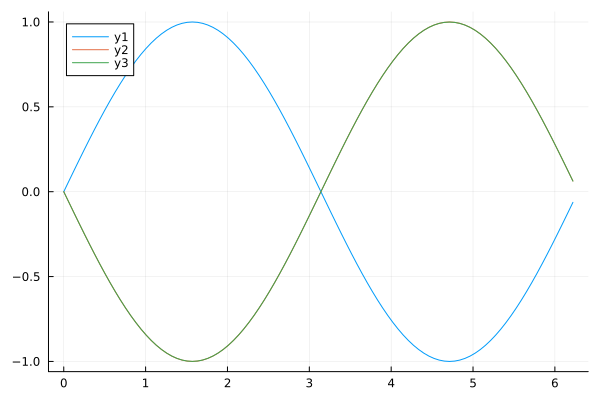

In [32]:
x = LinRange(0, 2*pi*(N-1)/N, N)
y = sin.(x)

plot(x, y)
plot!(x, d1(y))
plot!(x, d2(y))

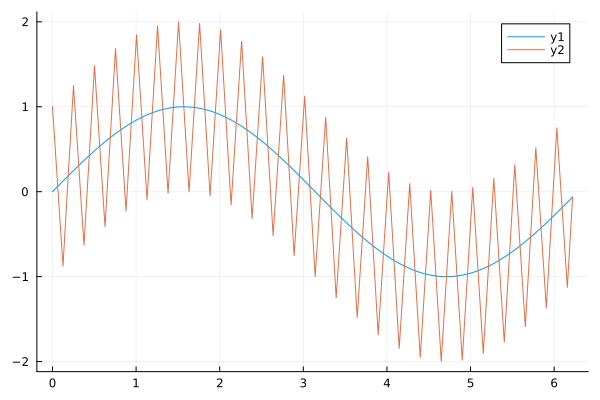

In [33]:
z = sin.(x) + sin.(x*N/4 .+ π/2 )
plot(x, y)
plot!(x, z)

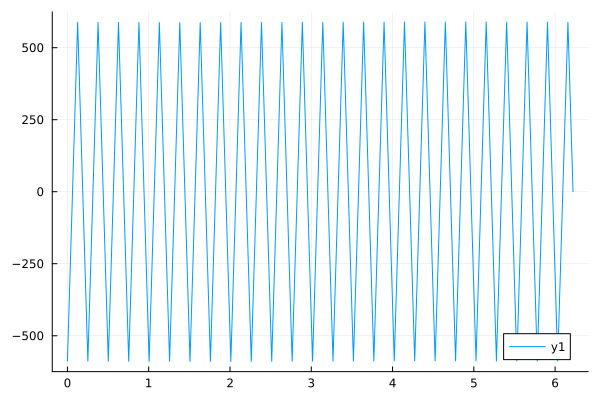

In [34]:
plot(x, d1(z))

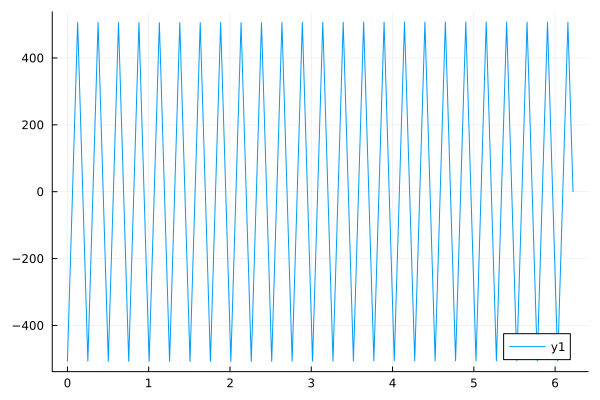

In [35]:
plot(x, d2(z))